In [ ]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import copy
import random
import math

In [2]:
import os
os.getcwd()

'c:\\Users\\WINDOWS\\Desktop\\vscode\\python\\IC'

# Abaixo está a rede neural usada nesse código

Foi usada o Sequential do Tensorflow com uma camada de entrada com 128 nuerônios recebendo dados de 784 pixels cada, e uma camada de saída de 10 neurônios (um para cada possibilidade de saída). Não há camada oculta. Esse tipo de estrutura foi assim feita pois: O problema a ser "resolvido" é simples, e para acelerar os resultados obtidos em cada teste.

Além disso, a função de loss escolhinda foi a SparseCategoricalCrossentropy e o otimizador de gradientes foi o SGD. Para mais detalhes, confira a rede abaixo

In [3]:
np.random.seed(0)
tf.random.set_seed(0)
TAXA = 0.001
MAXIMO = 4
class Model():
  @staticmethod
  def create_model():
    model = keras.models.Sequential(
        [
            keras.layers.Dense(units=128, activation='relu', input_shape=(784,)),
            keras.layers.Dense(10, activation="softmax")
        ]
    )
    otimizador = keras.optimizers.SGD(TAXA)
    model.compile(
        optimizer=otimizador,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [4]:
modelo_m = Model.create_model()
modelo_m.summary()

c:\Users\WINDOWS\Desktop\vscode\python\ambienteVirtual\myvenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
modelo_m.get_weights()

[array([[-0.05093727, -0.06193868,  0.00217639, ...,  0.00502359,
          0.07241672, -0.05620014],
        [-0.0007083 ,  0.06978672, -0.05160197, ..., -0.01996815,
          0.0290708 ,  0.04284476],
        [-0.04747893,  0.07308871, -0.02038545, ..., -0.05746469,
          0.04936109,  0.00698379],
        ...,
        [-0.04729582, -0.05245578, -0.03405328, ...,  0.04866684,
          0.02720799, -0.05163167],
        [-0.0023982 ,  0.04037524, -0.01076604, ..., -0.04788486,
         -0.00059897,  0.07931591],
        [-0.05699138,  0.01978256, -0.02806481, ...,  0.06318062,
         -0.08063905,  0.03712538]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

# distribuição dos dados

Afim de se obter resultados mais generalizáveis, os usuários locais desse aprendizado federado seguem uma distribuição razoavelmente normal. A rede conta com 42 usuários cada um contendo dados com diferentes variedades de dados.

A distribuição dos clientes conta com: média de 5,5 variedades, desvio padrão de 1,93, grau de Assimetria de zero e grau de curtose de 0.01.

Para mais informações consulte os dados abaixo

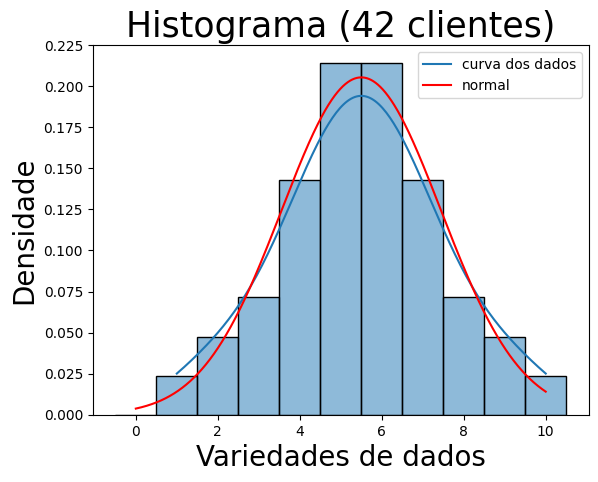

In [6]:
dados = [1,2,2,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,8,8,8,9,9,10]
ax = sns.histplot(dados, bins=np.arange(12) - 0.5, stat='density', kde=True)
ax.set_xlabel("Variedades de dados", size=20)
ax.set_ylabel('Densidade', size=20)
ax.set_title(f"Histograma ({len(dados)} clientes)", size=25)

numpy_range = np.arange(0,10,0.001) 
plt.plot(numpy_range, stats.norm.pdf(numpy_range, np.mean(dados), np.std(dados)), 'r', label='normal')
plt.legend(labels=['curva dos dados', 'normal'])
TOTAL = len(dados)

## Faz com que os mesmos clientes compartilhem o mesmo conjunto de dados

In [7]:
client_init = dados

mesma_variedade = []
for i in range(TOTAL):
    j = dados[i]
    dado = np.random.permutation(10)[:j]
    mesma_variedade.append(dado)

In [8]:
c1 = os.getcwd() + "\\mnist\\client\\non-iid-0.1-100\\"
c2 = "_train.pickle"
c3 = "_test.pickle"
aa = []
for i in range(TOTAL):
    variedade = mesma_variedade[client_init[i]-1]
    temp = pd.read_pickle((c1 + str(i+1) + c2))
    temp1 = pd.read_pickle((c1 + str(i+1) + c3))
    train = temp[temp['label'].isin(variedade)]
    aa.append(train.shape[0])
maximo_de_itens = max(aa)
indd = aa.index(maximo_de_itens) +1
tem = pd.read_pickle((c1 + str(indd) + c3))
indd = tem.shape[0]
atual = TOTAL + 1
if atual>100:
    atual =10

In [9]:
LISTA = [1, 2, 3, 4, 5]

In [10]:
def proximo():
    global LISTA
    if(len(LISTA)>0):
        yield LISTA.pop()
        proximo()
    else:
        return


Abaixo estão respresentadas as fórmulas contidas em:

	0 = Chen, H., Huang, S., Zhang, D., Xiao, M., Skoglund, M., and Poor, H. V. (2022). Federa-
	ted learning over wireless iot networks with optimized communication and resources.
	IEEE Internet of Things Journal, 9(17):16592–16605.

	1 = Fórmula criada (FC)

	2 = Cenário Randômico correspondente à 0 ou 1

In [11]:
def formulas(formula:int, **kwords):

    if formula == 0:
        N = kwords['numero_de_clientes_na_rede']
        n = kwords['taxa_de_aprendizado']
        soma_dos_quadrados_dos_gradientes = 0
        soma_dos_quadrados_dos_pesos = 0
        zipado = list(zip(kwords['atualGradServidor'], kwords['penultimoGradServidor']))
        zipado_1 = list(zip(kwords['atualPeso'], kwords['penultinoPeso']))
        for ps1, ps2 in zipado:
            ps1 = ps1.numpy()
            ps2 = ps2.numpy()
            if isinstance(ps1[0], np.ndarray):
                for indice in range(len(ps1)):
                    soma_dos_quadrados_dos_gradientes += sum(  (ps1[indice] - ps2[indice])**2  )
            else:
                soma_dos_quadrados_dos_gradientes += sum(  (ps1 - ps2)**2  )
        for ps1, ps2 in zipado_1:
            if isinstance( ps1[0], np.ndarray):
                for indice in range(len(ps1)):
                    soma_dos_quadrados_dos_pesos += sum(  (ps1[indice] - ps2[indice])**2  )
            else:
                soma_dos_quadrados_dos_pesos += sum(  (ps1 - ps2)**2  )
        soma_dos_quadrados_dos_gradientes = ( (soma_dos_quadrados_dos_gradientes ** 0.5) ** 2 )
        soma_dos_quadrados_dos_pesos = ( (soma_dos_quadrados_dos_pesos ** 0.5) **2 )
        g = N*N*n*n*soma_dos_quadrados_dos_gradientes
        p = soma_dos_quadrados_dos_pesos
        inicio = len(kwords['valores_anteriores'])
        for i in range(inicio):
            p += kwords['valores_anteriores'][i]*(0.9**(inicio-i))
        kwords['valores_anteriores'].append(soma_dos_quadrados_dos_pesos)
        if len(kwords['valores_anteriores']) > 4:
            kwords['valores_anteriores'].pop(0)
            return ( g>=p, g, p, kwords['valores_anteriores'])
        return ( g>=p, g, p, kwords['valores_anteriores'])

    if formula == 1:
        porcentagem = np.linalg.norm(np.array(kwords['atualPeso'][-1])) / np.linalg.norm(np.array(kwords['penultinoPeso'][-1]))
        kwords['valores_anteriores'].append(round(porcentagem,4))
        if len(kwords['valores_anteriores']) >=3:
            novo_guardar = None
            if len(kwords['valores_anteriores']) > kwords['maximoDeItens']:
                novo_guardar = kwords['valores_anteriores'][0]
                kwords['valores_anteriores'].pop(0)
                coeficiente_de_determinacao = ( np.corrcoef( list(range( 1, len(kwords['valores_anteriores'])+1)) , kwords['valores_anteriores'])[0,1] ) ** 2
                media = np.mean(kwords['valores_anteriores'])
                if media==0:
                    media = 0.00001
                media_relativa = ( np.std(kwords['valores_anteriores']) / media)
                if(coeficiente_de_determinacao >= 0.90 and media>=(1 - kwords['n0'] ) and media<=(1 + kwords['n0'] )):
                    kwords['valores_anteriores'].pop(-1)
                    if novo_guardar != None:
                        valores_anteriores = [novo_guardar] + kwords['valores_anteriores']
                    return (True, valores_anteriores,coeficiente_de_determinacao, media_relativa )
                return (False, kwords['valores_anteriores'], coeficiente_de_determinacao, media_relativa )
        return (False, kwords['valores_anteriores'], -1, -1 )

    if formula == 2:
        return bool(next(proximo()))

## Escolhe os clientes das rodadas

In [12]:
novo_numero_de_rodadas = 420
total_de_clientes = TOTAL
clientes_min = 3
def listaDeClientesSelecionados(novo_numero_de_rodadas :int, total_de_clientes : int, clientes_min :int):
    lista2= []
    for i in range(novo_numero_de_rodadas):
        lista2.append(np.random.permutation(total_de_clientes)[:clientes_min] +1)
    return lista2
nova_lista_de_clientes = listaDeClientesSelecionados(novo_numero_de_rodadas, total_de_clientes, clientes_min)

## Cliente e Servidor que participarão do aprendizado federado

In [16]:
class Cliente():
    def __init__(self, cid, client_init = client_init, servidor=False, pesosIguais = True):
        self.cid = int(cid)
        self.model = copy.deepcopy(modelo_m)
        self.servidor = servidor
        self.client_init = client_init
        self.pesosIguais = pesosIguais
        self.x_treino = None
        self.x_teste = None
        self.y_treino = None
        self.y_teste = None
        self.contando = 0
        self.copiaObsoleta = (0, (0, 0))
        self.penultimoGradServidor = 0
        self.atualGradServidor = 0
        self.penultimoPeso = 0
        self.atualPeso = 0
        self.valores_anteriores = []
    
    def treino_e_teste_F1(self, pesosIguais=False):
        c1 = os.getcwd() + "\\mnist\\client\\non-iid-0.1-100\\"
        c2 = "_train.pickle"
        c3 = "_test.pickle"
        variedade = mesma_variedade[client_init[self.cid-1]-1]
        temp = pd.read_pickle((c1 + str(self.cid) + c2))
        temp1 = pd.read_pickle((c1 + str(self.cid) + c3))
        train = temp[temp['label'].isin(variedade)]
        test = temp1[temp1['label'].isin(variedade)]
        if (train.shape[0] < maximo_de_itens) and pesosIguais:
            temporario = pd.read_pickle((c1 + str(self.cid+42) +c2))
            temporario1 = temporario[temporario['label'].isin(variedade)]
            temporario2 = pd.read_pickle((c1 + str(self.cid+42) + c2))
            temporario3 = temporario2[temporario['label'].isin(variedade)]
            train = pd.concat([train, temporario1], ignore_index=True)
            test = pd.concat([test, temporario3], ignore_index=True)
            if train.shape[0] > maximo_de_itens:
                retirar = train.shape[0] - maximo_de_itens + 1
                if test.shape[0] > indd:
                    novo_retirar = test.shape[0] - indd + 1
                    test = test.iloc[:-novo_retirar]
                train = train.iloc[:-retirar]
        return (train, test)

    def load_data(self):
        train, test = self.treino_e_teste_F1(self.pesosIguais)

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        x_test = test.drop(['label'], axis=1)
        y_test = test['label']
        return(x_train, y_train), (x_test, y_test)

    def preencher(self, gradiente, peso):
        self.penultimoGradServidor = copy.deepcopy(self.atualGradServidor)
        self.penultimoPeso = copy.deepcopy(self.atualPeso)
        self.atualGradServidor = gradiente
        self.atualPeso = peso
    

    def fit(self, parametros, gradienteServidor, formula, ComparaModelos=False, n0_=0.05):
        (self.x_treino, self.y_treino), (self.x_teste, self.y_teste) = self.load_data()

        self.model.set_weights(parametros)
        history = self.model.fit(self.x_treino, self.y_treino, epochs=5, batch_size=128, validation_data=(self.x_teste, self.y_teste), verbose=False) # type: ignore
        sample_size = len(self.x_treino)
        (self.x_treino, self.y_treino), (self.x_teste, self.y_teste) = (None,None), (None,None)
        if self.servidor and (not ComparaModelos):
            self.copiaObsoleta = ( self.model.get_weights(), (history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
            self.preencher(gradienteServidor, self.model.get_weights())
        elif ComparaModelos:
            self.preencher(gradienteServidor, self.model.get_weights())
            #atualGradServidor, penultimoGradServidor, atualPeso, penultinoPeso, valores_anteriores, numero_de_clientes_na_rede = TOTAL, taxa_de_aprendizado = TAXA
            valores = formulas(formula, atualGradServidor=self.atualGradServidor, penultimoGradServidor=self.penultimoGradServidor, atualPeso=self.atualPeso, penultinoPeso=self.penultimoPeso, valores_anteriores=self.valores_anteriores, numero_de_clientes_na_rede = TOTAL, taxa_de_aprendizado = TAXA, maximoDeItens=MAXIMO, n0=n0_)
            if formula == 0:
                booleano, grad, pes, self.valores_anteriores = valores # type: ignore
                booleano = not booleano
            elif formula == 1:
                booleano, self.valores_anteriores, determinacao, media_relativa = valores # type: ignore
            elif formula == 2:
                booleano = valores # type: ignore

            if (self.contando < 3) and booleano:
                if formula ==0:
                    print(f"{self.cid} -> {self.copiaObsoleta[1][1]} grad = {grad:.3f}, pes = {pes: .3f} (copia)")
                elif formula==1:
                    print(f"{self.cid} -> {self.copiaObsoleta[1][1]} determinacao = {determinacao:.3f}  relativa = {media_relativa:.3f} num = {self.valores_anteriores} (copia)")
                elif formula == 2:
                    print(f"{self.cid} -> {self.copiaObsoleta[1][1]} (cópia)")
                self.contando+=1
                return self.copiaObsoleta[0], sample_size, {"val_accuracy": self.copiaObsoleta[1][1], "val_loss": self.copiaObsoleta[1][0]},0
            else:
                self.copiaObsoleta = ( self.model.get_weights(), (history.history['val_loss'][-1], history.history['val_accuracy'][-1]) )
                if self.contando >=3: 
                    if formula==0 :
                        print(f"{self.cid} -> {history.history['val_accuracy'][-1]} grad = {grad:.3f}, pes = {pes: .3f} (novo, aconteceu)")
                    elif formula==1:
                        print(f"{self.cid} -> {history.history['val_accuracy'][-1]} determinacao = {determinacao:.3f}  relativa = {media_relativa:.3f} num = {self.valores_anteriores} (novo, aconteceu)")
                    elif formula==2:
                        print(f"{self.cid} -> {self.copiaObsoleta[1][1]} (novo, aconteceu)")
                    if(len(self.valores_anteriores)>0): # type: ignore
                        self.valores_anteriores.pop(0) # type: ignore
                else:
                    if formula==0:
                        print(f"{self.cid} -> {history.history['val_accuracy'][-1]} grad = {grad:.3f}, pes = {pes: .3f} (novo)")
                    elif formula==1:
                        print(f"{self.cid} -> {history.history['val_accuracy'][-1]} determinacao = {determinacao:.3f}  relativa = {media_relativa:.3f} num = {self.valores_anteriores} (novo)")
                    elif formula==2:
                        print(f"{self.cid} -> {self.copiaObsoleta[1][1]} (novo)")
                self.contando=0
                return self.model.get_weights(), sample_size, {"val_accuracy": history.history['val_accuracy'][-1], "val_loss": history.history['val_loss'][-1]},1
        print(f"{self.cid} -> {history.history['val_accuracy'][-1]}")
        return self.model.get_weights(), sample_size, {"val_accuracy": history.history['val_accuracy'][-1], "val_loss": history.history['val_loss'][-1]},1
    
    def evaluate(self, parameters):
        (self.x_treino, self.y_treino), (self.x_teste, self.y_teste) = self.load_data()

        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.x_teste, self.y_teste, verbose=False) # type: ignore

        (self.x_treino, self.y_treino), (self.x_teste, self.y_teste) = (None,None), (None,None)

        return loss, accuracy

In [17]:
class Server():
    def __init__(self, n_rounds, min_fit_clients, clientes, formula=0, servidor=True, pesosIguais=True, n0=0.05):
        self.n_rounds = n_rounds
        self.min_fit_clients = min_fit_clients
        self.servidor = servidor

        self.server_round = 0
        self.formula = formula
        self.selected_clients = []
        self.clienteXEstaAqui = []
        self.pesosIguais = pesosIguais
        self.n0 = n0
        self.model = copy.deepcopy(modelo_m)
        self.w_global = self.model.get_weights()
        
        self.clients_model_list = []
        self.clientes = clientes
        self.create_models()
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()
        self.selecionados = []
        self.novos = []
        self.copias = []
    
    def create_models(self):
        usados = set()
        for i in self.clientes:
            for j in i:
                if(j not in usados):
                    self.clienteXEstaAqui.append(j)
                    usados.add(j)
                    self.clients_model_list.append(Cliente(j, servidor=self.servidor, pesosIguais = self.pesosIguais))
    
    def load_data(self):
        path = os.getcwd() + "\\mnist\\server"

        train = pd.read_pickle(f"{path}\\train.pickle")
        test = pd.read_pickle(f"{path}\\test.pickle")

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        test = pd.concat([test, train])
        x_test = test.drop(['label'], axis=1)
        y_test = test['label']
        return (x_train, y_train), (x_test, y_test)
    
    def aggregate_fit(self, weight_list, sample_sizes):
        self.w_global = []
        for weights in zip(*weight_list):
            weighted_sum = 0
            total_samples = sum(sample_sizes)
            for i in range(len(weights)):
                weighted_sum += weights[i] * sample_sizes[i]
            self.w_global.append(weighted_sum / total_samples)
    
    def configure_fit(self, index):
        self.selected_clients = self.clientes[index]
        print(f"selected_clients: {np.array(self.selected_clients)}")
    
    def fit(self):

        weight_list = []
        sample_sizes_list = []
        info_list = []
        funcao_de_loss = keras.losses.SparseCategoricalCrossentropy()
        with tf.GradientTape() as tape:
            predicao = self.model(tf.constant(self.x_train))
            loss = funcao_de_loss(self.y_train, predicao)
        gradientes = tape.gradient(loss, self.model.trainable_variables)
        for i, pos in enumerate(self.selected_clients):
            print(f"-------> [{i+1}] (R: {self.server_round+1}/{self.n_rounds}) CID: {pos}")

            if(pos not in self.selecionados or not(self.servidor)):
                self.selecionados.append(pos)
                weights, size, info, code = self.clients_model_list[self.clienteXEstaAqui.index(pos)].fit(parametros=self.w_global,  gradienteServidor=gradientes, formula=self.formula, n0_=self.n0)
            else:
                weights, size, info, code = self.clients_model_list[self.clienteXEstaAqui.index(pos)].fit(parametros=self.w_global, gradienteServidor=gradientes, formula=self.formula, ComparaModelos=True, n0_=self.n0)
                if code==0:
                    self.copias.append((self.server_round+1, len(self.copias) +1))
                else:
                    self.novos.append((self.server_round+1, len(self.novos) +1))
            weight_list.append(weights)
            sample_sizes_list.append(size)
            info_list.append(info)

        return weight_list, sample_sizes_list, {"acc_loss_local":[(pos, info_list[i]) for i, pos in enumerate(self.selected_clients)]}

    def centralized_evaluation(self):
        self.model.set_weights(self.w_global)
        loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=False)
        return loss, accuracy
    

## Exemplo de uso do Server para aplicação do algortimo de Chen, H. (0 zero)

In [ ]:
comf0 = Server(
            n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           pesosIguais=False,
           formula= 0,
           )

print(f"INÍCIO")

evaluate_list_comf0 = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

# Rodadas de comf0unicação
for comf0.server_round in range(comf0.n_rounds):
  comf0.configure_fit(comf0.server_round)
  weight_list, sample_sizes, info = comf0.fit()
  comf0.aggregate_fit(weight_list, sample_sizes)

  print(f"***************************")
  print(f"Avaliação centralizada: R: {comf0.server_round+1}")
  evaluate_loss, evaluate_accuracy = comf0.centralized_evaluation()
  print(f"evaluate_accuracy: {evaluate_accuracy}")

  evaluate_list_comf0["centralized"]["loss"].append(evaluate_loss)
  evaluate_list_comf0["centralized"]["accuracy"].append(evaluate_accuracy)

  print(f"-----------------")

print(f"centralized loss: ")
print(evaluate_list_comf0["centralized"]["loss"])
print(f"centralized accuracy: ")
print(evaluate_list_comf0["centralized"]["accuracy"])
print(f"FIM")

## Exemplo de uso do Server para aplicação do algortimo FC com $n_0$ de 0.01

In [ ]:
comf1_001 = Server(n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           pesosIguais=False,
           formula=1,
           n0=0.01
)

print(f"INÍCIO")

evaluate_list_comf1_001 = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

# Rodadas de comf1_001unicação
for comf1_001.server_round in range(comf1_001.n_rounds):
  comf1_001.configure_fit(comf1_001.server_round)
  weight_list, sample_sizes, info = comf1_001.fit()
  comf1_001.aggregate_fit(weight_list, sample_sizes)

  print(f"***************************")
  print(f"Avaliação centralizada: R: {comf1_001.server_round+1}")
  evaluate_loss, evaluate_accuracy = comf1_001.centralized_evaluation()
  print(f"evaluate_accuracy: {evaluate_accuracy}")

  evaluate_list_comf1_001["centralized"]["loss"].append(evaluate_loss)
  evaluate_list_comf1_001["centralized"]["accuracy"].append(evaluate_accuracy)

  print(f"-----------------")

print(f"centralized loss: ")
print(evaluate_list_comf1_001["centralized"]["loss"])
print(f"centralized accuracy: ")
print(evaluate_list_comf1_001["centralized"]["accuracy"])
print(f"FIM")

## Exemplo de uso do Server para aplicação do randômico correspondente ao FC com $n_0$ de 0.01

In [ ]:
rodadas_copias = []
crescimento_copias = []
for j,i in comf1_001.copias:
    rodadas_copias.append(j)
    crescimento_copias.append(i)

total_de_copias_usadas = crescimento_copias[-1]
lista = ([1] * total_de_copias_usadas)
lista.extend([0]*(novo_numero_de_rodadas*clientes_min - total_de_copias_usadas - TOTAL))

for i in range(100):
  random.shuffle(lista)

LISTA = lista


comf2_2 = Server(n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           pesosIguais=False,
           formula = 2,
)

print(f"INÍCIO")

evaluate_list_comf2_2 = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

# Rodadas de comf2_2unicação
for comf2_2.server_round in range(comf2_2.n_rounds):
  comf2_2.configure_fit(comf2_2.server_round)
  weight_list, sample_sizes, info = comf2_2.fit()
  comf2_2.aggregate_fit(weight_list, sample_sizes)

  print(f"***************************")
  print(f"Avaliação centralizada: R: {comf2_2.server_round+1}")
  evaluate_loss, evaluate_accuracy = comf2_2.centralized_evaluation()
  print(f"evaluate_accuracy: {evaluate_accuracy}")

  evaluate_list_comf2_2["centralized"]["loss"].append(evaluate_loss)
  evaluate_list_comf2_2["centralized"]["accuracy"].append(evaluate_accuracy)

  print(f"-----------------")

print(f"centralized loss: ")
print(evaluate_list_comf2_2["centralized"]["loss"])
print(f"centralized accuracy: ")
print(evaluate_list_comf2_2["centralized"]["accuracy"])
print(f"FIM")

## Exemplo de uso do Server sem aplicação alguma de algoritmos de economia de energia

In [ ]:
sem = Server(n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           servidor= False,
           pesosIguais=False,
)

print(f"INÍCIO")

evaluate_list_sem = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

# Rodadas de comunicação
for sem.server_round in range(sem.n_rounds):
  sem.configure_fit(sem.server_round)
  weight_list, sample_sizes, info = sem.fit()
  sem.aggregate_fit(weight_list, sample_sizes)

  print(f"***************************")
  print(f"Avaliação centralizada: R: {sem.server_round+1}")
  evaluate_loss, evaluate_accuracy = sem.centralized_evaluation()
  print(f"evaluate_accuracy: {evaluate_accuracy}")

  evaluate_list_sem["centralized"]["loss"].append(evaluate_loss)
  evaluate_list_sem["centralized"]["accuracy"].append(evaluate_accuracy)

  print(f"-----------------")
print(f"centralized loss: ")
print(evaluate_list_sem["centralized"]["loss"])
print(f"centralized accuracy: ")
print(evaluate_list_sem["centralized"]["accuracy"])
print(f"FIM")

# Funções que resultaram nos dados apresentados no artigo e sua execução em Threads para acelerar o processo

In [ ]:
def f_Sem(result, index):
    sem = Server(n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           servidor= False,
           pesosIguais=False,
    )

    evaluate_list_sem = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

    for sem.server_round in range(sem.n_rounds):
        sem.configure_fit(sem.server_round)
        weight_list, sample_sizes, info = sem.fit()
        sem.aggregate_fit(weight_list, sample_sizes)

        evaluate_loss, evaluate_accuracy = sem.centralized_evaluation()

        evaluate_list_sem["centralized"]["loss"].append(evaluate_loss)
        evaluate_list_sem["centralized"]["accuracy"].append(evaluate_accuracy)
    result[index] = (evaluate_list_sem, sem.copias, sem.novos)


def f_Fev(result, index):
    fev = Server(
            n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           pesosIguais=False,
           formula= 0,
           )

    evaluate_list_fev = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}
    for fev.server_round in range(fev.n_rounds):
        fev.configure_fit(fev.server_round)
        weight_list, sample_sizes, info = fev.fit()
        fev.aggregate_fit(weight_list, sample_sizes)

        evaluate_loss, evaluate_accuracy = fev.centralized_evaluation()

        evaluate_list_fev["centralized"]["loss"].append(evaluate_loss)
        evaluate_list_fev["centralized"]["accuracy"].append(evaluate_accuracy)
    result[index] = (evaluate_list_fev, fev.copias, fev.novos)


def f_FC_1(result, index):
    fc_1 = Server(n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           pesosIguais=False,
           formula=1,
           n0=0.01
    )

    evaluate_list_fc_1 = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

    for fc_1.server_round in range(fc_1.n_rounds):
        fc_1.configure_fit(fc_1.server_round)
        weight_list, sample_sizes, info = fc_1.fit()
        fc_1.aggregate_fit(weight_list, sample_sizes)

        evaluate_loss, evaluate_accuracy = fc_1.centralized_evaluation()

        evaluate_list_fc_1["centralized"]["loss"].append(evaluate_loss)
        evaluate_list_fc_1["centralized"]["accuracy"].append(evaluate_accuracy)
    result[index] = (evaluate_list_fc_1, fc_1.copias, fc_1.novos)


def f_FC_5(result, index):
    fc_5 = Server(n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           pesosIguais=False,
           formula=1,
           n0=0.05
    )

    evaluate_list_fc_5 = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

    for fc_5.server_round in range(fc_5.n_rounds):
        fc_5.configure_fit(fc_5.server_round)
        weight_list, sample_sizes, info = fc_5.fit()
        fc_5.aggregate_fit(weight_list, sample_sizes)

        evaluate_loss, evaluate_accuracy = fc_5.centralized_evaluation()

        evaluate_list_fc_5["centralized"]["loss"].append(evaluate_loss)
        evaluate_list_fc_5["centralized"]["accuracy"].append(evaluate_accuracy)
    result[index] = (evaluate_list_fc_5, fc_5.copias, fc_5.novos)


def f_FC_20(result, index):
    fc_20 = Server(n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           pesosIguais=False,
           formula=1,
           n0=0.2
    )

    evaluate_list_fc_20 = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

    for fc_20.server_round in range(fc_20.n_rounds):
        fc_20.configure_fit(fc_20.server_round)
        weight_list, sample_sizes, info = fc_20.fit()
        fc_20.aggregate_fit(weight_list, sample_sizes)

        evaluate_loss, evaluate_accuracy = fc_20.centralized_evaluation()

        evaluate_list_fc_20["centralized"]["loss"].append(evaluate_loss)
        evaluate_list_fc_20["centralized"]["accuracy"].append(evaluate_accuracy)
    result[index] = (evaluate_list_fc_20, fc_20.copias, fc_20.novos)


total_de_copias_usadas = 9
lista = ([1] * total_de_copias_usadas)
lista.extend([0]*(novo_numero_de_rodadas*clientes_min - total_de_copias_usadas - TOTAL))

for _ in range(100):
    random.shuffle(lista)

LISTA = lista

def f_Ramdon_9(result, index):
    random_9 = Server(n_rounds=novo_numero_de_rodadas,
           min_fit_clients=clientes_min,
           clientes= nova_lista_de_clientes,
           pesosIguais=False,
           formula = 2,
    )


    evaluate_list_random_9 = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

    for random_9.server_round in range(random_9.n_rounds):
        random_9.configure_fit(random_9.server_round)
        weight_list, sample_sizes, info = random_9.fit()
        random_9.aggregate_fit(weight_list, sample_sizes)

        evaluate_loss, evaluate_accuracy = random_9.centralized_evaluation()

        evaluate_list_random_9["centralized"]["loss"].append(evaluate_loss)
        evaluate_list_random_9["centralized"]["accuracy"].append(evaluate_accuracy)
    result[index] = (evaluate_list_random_9, random_9.copias, random_9.novos)

In [ ]:
import threading

# Lista para armazenar os resultados
resultados = [None] * 6

# Lista de funções
funcoes = [f_Sem, f_Fev, f_FC_1, f_Ramdon_9, f_FC_5, f_FC_20]

# Criar e iniciar threads para cada função
threads = []
for i, func in enumerate(funcoes):
    thread = threading.Thread(target=func, args=(resultados, i))
    threads.append(thread)
    thread.start()

# Aguardar a conclusão de todas as threads
for thread in threads:
    thread.join()


# Gráfico da FC de 1%, 5%, e 20%

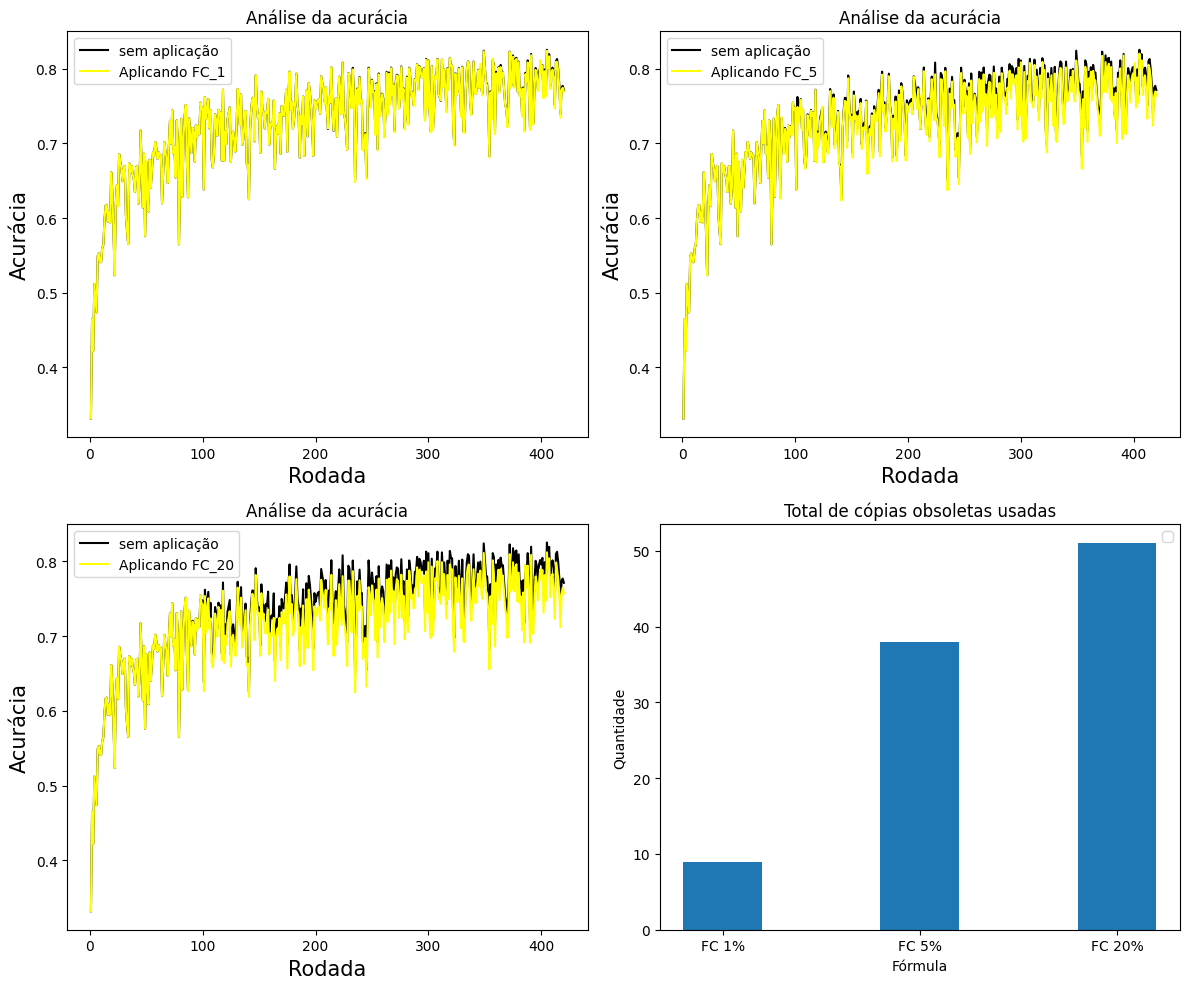

In [ ]:
x = range(1,novo_numero_de_rodadas+1,1)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0][0].plot(x, resultados[0][0]['centralized']['accuracy'], color = 'black', label='sem aplicação')
axs[0][0].plot(x, resultados[2][0]['centralized']['accuracy'], color='yellow', label='Aplicando FC_1')
axs[0][0].legend()
axs[0][0].set_xlabel('Rodada', size=15)
axs[0][0].set_ylabel('Acurácia', size=15)
axs[0][0].set_title('Análise da acurácia')
axs[0][1].plot(x, resultados[0][0]['centralized']['accuracy'], color = 'black', label='sem aplicação')
axs[0][1].plot(x, resultados[4][0]['centralized']['accuracy'], color='yellow', label='Aplicando FC_5')
axs[0][1].set_xlabel('Rodada', size=15)
axs[0][1].set_ylabel('Acurácia', size=15)
axs[0][1].legend()
axs[0][1].set_title('Análise da acurácia')
axs[1][0].plot(x, resultados[0][0]['centralized']['accuracy'], color = 'black', label='sem aplicação')
axs[1][0].plot(x, resultados[5][0]['centralized']['accuracy'], color='yellow', label='Aplicando FC_20')
axs[1][0].set_xlabel('Rodada', size=15)
axs[1][0].set_ylabel('Acurácia', size=15)
axs[1][0].legend()
axs[1][0].set_title('Análise da acurácia')
axs[1][1].bar(['FC 1%', 'FC 5%', 'FC 20%'], [resultados[2][1][-1][1], resultados[4][1][-1][1], resultados[5][1][-1][1]], width=0.4)
axs[1][1].set_title("Total de cópias obsoletas usadas")
axs[1][1].set_xlabel("Fórmula")
axs[1][1].set_ylabel("Quantidade")
axs[1][1].legend()
plt.tight_layout()
plt.show()

# Gráfico FEV e FC de 1%

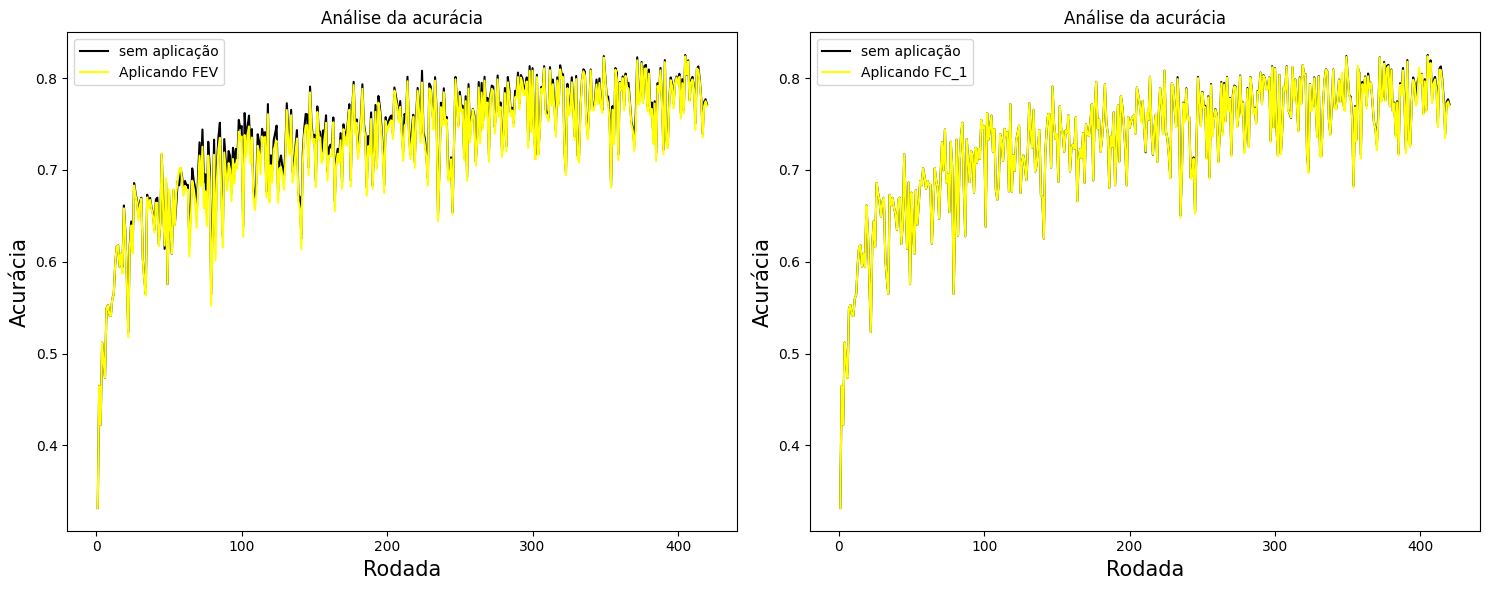

In [85]:
x = range(1,novo_numero_de_rodadas+1,1)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(x, resultados[0][0]['centralized']['accuracy'], color = 'black', label='sem aplicação')
axs[0].plot(x, resultados[1][0]['centralized']['accuracy'], color='yellow', label='Aplicando FEV')
axs[0].legend()
axs[0].set_xlabel('Rodada', size=15)
axs[0].set_ylabel('Acurácia', size=15)
axs[0].set_title('Análise da acurácia')
axs[1].plot(x, resultados[0][0]['centralized']['accuracy'], color = 'black', label='sem aplicação')
axs[1].plot(x, resultados[2][0]['centralized']['accuracy'], color='yellow', label='Aplicando FC_1')
axs[1].set_xlabel('Rodada', size=15)
axs[1].set_ylabel('Acurácia', size=15)
axs[1].legend()
axs[1].set_title('Análise da acurácia')
plt.tight_layout()
plt.show()

# Gráfico FC 1% e cenário Randômico correspondente

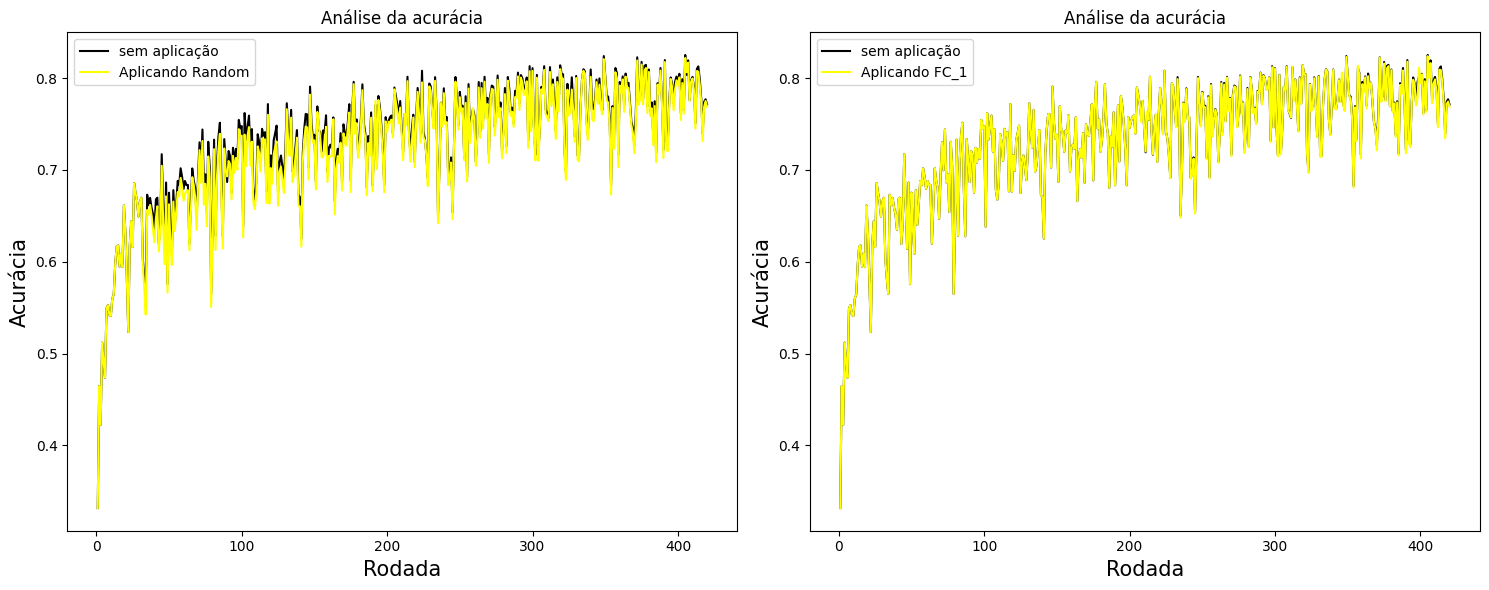

In [97]:
x = range(1,novo_numero_de_rodadas+1,1)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[1].plot(x, resultados[0][0]['centralized']['accuracy'], color = 'black', label='sem aplicação')
axs[1].plot(x, resultados[2][0]['centralized']['accuracy'], color='yellow', label='Aplicando FC_1')
axs[1].legend()
axs[1].set_xlabel('Rodada', size=15)
axs[1].set_ylabel('Acurácia', size=15)
axs[1].set_title('Análise da acurácia')
axs[0].plot(x, resultados[0][0]['centralized']['accuracy'], color = 'black', label='sem aplicação')
axs[0].plot(x, resultados[3][0]['centralized']['accuracy'], color='yellow', label='Aplicando Random')
axs[0].set_xlabel('Rodada', size=15)
axs[0].set_ylabel('Acurácia', size=15)
axs[0].legend()
axs[0].set_title('Análise da acurácia')
plt.tight_layout()
plt.show()

# Dados numéricos dos resultados

In [105]:
economia_da_FC_1 = [tupla[0] for tupla in resultados[2][1]]
economia_da_FC_1

[208, 233, 310, 346, 357, 365, 370, 398, 399]

In [106]:
economia_da_FEV = [tupla[0] for tupla in resultados[1][1]]
economia_da_FEV

[18, 47, 47, 55, 65, 68, 71, 264]

In [107]:
L1_Fc_1 = sum([math.fabs(i-j) for i,j in list(zip(resultados[0][0]['centralized']['accuracy'], resultados[2][0]['centralized']['accuracy']))])
L1_Fc_1

0.30890023708343506

In [108]:
L1_Fev = sum([math.fabs(i-j) for i,j in list(zip(resultados[0][0]['centralized']['accuracy'], resultados[1][0]['centralized']['accuracy']))])
L1_Fev

2.5809566974639893

In [109]:
L1_Fc_5 = sum([math.fabs(i-j) for i,j in list(zip(resultados[0][0]['centralized']['accuracy'], resultados[4][0]['centralized']['accuracy']))])
L1_Fc_5

2.4566566348075867

In [110]:
L1_Fc_20 = sum([math.fabs(i-j) for i,j in list(zip(resultados[0][0]['centralized']['accuracy'], resultados[5][0]['centralized']['accuracy']))])
L1_Fc_20

5.884271025657654